In [2]:
from pathlib import Path

from IPython.display import Markdown as md

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib_venn import venn3
import pandas as pd
import seaborn as sns

import numpy as np

from tracking_grants import references_f, articles_f, wos_f, altmetric_f
from tracking_grants import tool_name, email, ncbi_api_key



In [3]:
from tqdm.auto import tqdm
import requests
from ratelimit import limits, sleep_and_retry
import re

tqdm.pandas()

from datetime import datetime

In [10]:
# Load references
refs = pd.read_csv(references_f, index_col="reference_id")

In [11]:
# Load matched articles
articles = pd.read_csv(articles_f)
articles.DOI = articles.DOI.str.lower()

In [108]:
class ClinicalTrials():
    def __init__(self, fields):
        self.baseurl = "https://clinicaltrials.gov/api/query/study_fields"
        self.fields = fields
        self.params = {
            "fields": ",".join(self.fields),
            "min_rnk": 1,
            "max_rnk": None,
            "fmt": "json"
        }
        
    def query_trials(self, pmid):
        params = self.params
        params['expr'] = f"{pmid}[PUBMED-IDS]"
        
        try:
            r =  requests.get(self.baseurl, params=params)
            if r.status_code == 200:
                resp = r.json()['StudyFieldsResponse']
                if resp['NStudiesFound'] > 0:
                    return resp['StudyFields']
                else:
                    return None
            else:
                return None
        except Exception as e:
            return e

In [127]:
fields = ["NCTId", "BriefTitle", "Condition", "OverallStatus", "Phase"]
ct = ClinicalTrials(fields)

clinicaltrials = pd.DataFrame(columns = ['doi', 'pmid'] + fields + ['ts'])

df = articles

dois = df.DOI.tolist()
pmids = df.pmid.tolist()

for doi, pmid in tqdm(zip(dois, pmids), total=len(dois)):
    if pmid:
        ts = datetime.now().isoformat()
        trials = ct.query_trials(pmid)
        if trials:
            for t in trials:
                row = [doi, pmid]
                for f in fields:
                    if f in t:
                        row.append(t[f])
                    else:
                        row.append(None)
                row.append(ts)
                
                clinicaltrials.loc[len(clinicaltrials)+1] = row

In [129]:
clinicaltrials.to_csv("clinicaltrials.csv")

In [4]:
clinicaltrials = pd.read_csv("clinicaltrials.csv")

In [5]:
for c in ['NCTId', 'BriefTitle', 'OverallStatus', 'Phase']:
    clinicaltrials[c] = clinicaltrials[c].map(lambda x: eval(x)[0] if len(eval(x))>0 else None)

In [19]:
articles.pmid.dropna().nunique()

5943

In [20]:
clinicaltrials.pmid.nunique()

231

In [180]:
clinicaltrials.Phase.value_counts()

Phase 2           89
Phase 1           79
Not Applicable    57
Phase 3           24
Early Phase 1      7
Phase 4            4
Name: Phase, dtype: int64

In [201]:
clinicaltrials.Condition = clinicaltrials.Condition.map(lambda x: eval(x))

In [37]:
df = articles.merge(clinicaltrials, left_on="DOI", right_on="doi")
df = df.groupby("program").NCTId.nunique().to_frame("Clinical Trials")
df["%"] = df['Clinical Trials'].div(articles.groupby("program").size()/100)
df.round(2)

,Clinical Trials,%
program,,
NFRP,9,4.48
PCRP,203,2.74
PRORP,17,5.07
TSCRP,9,4.48


,Clinical Trials
program,
NFRP,9
PCRP,203
PRORP,17
TSCRP,9


In [202]:
clinicaltrials.Condition

0      [Tuberous Sclerosis, Lymphangioleiomyomatosis,...
1                             [Lymphangioleiomyomatosis]
2                    [Angiofibromas, Tuberous Sclerosis]
3      [Tuberous Sclerosis, Neurofibromatoses, Angiof...
4             [Angiofibroma of Face, Tuberous Sclerosis]
                             ...                        
296    [Post-Amputation Pain, Phantom Limb Pain, Resi...
297                                              [Burns]
298    [Tendinopathy, Adhesions Nos Postoperative, Sc...
299                   [Burns, Wound of Skin, Skin Wound]
300                                  [Rotator Cuff Tear]
Name: Condition, Length: 301, dtype: object

In [217]:
pd.get_dummies(clinicaltrials.Condition.apply(pd.Series).stack()).sum().sort_values(ascending=False).head(20)

Prostate Cancer                                    111
Recurrent Prostate Cancer                           12
Prostatic Neoplasms                                  7
Metastatic Castration-resistant Prostate Cancer      7
Adenocarcinoma of the Prostate                       7
D009360                                              6
D064129                                              6
D035683                                              6
D014408                                              6
D011471                                              6
Breast Cancer                                        6
Cancer                                               6
Hormone-resistant Prostate Cancer                    5
Stage IV Prostate Cancer                             5
Prostate Adenocarcinoma                              5
Pancreatic Cancer                                    4
Prostatic Neoplasm                                   4
Lymphangioleiomyomatosis                             4
Tuberous S

In [ ]:
articles

In [218]:
clinicaltrials

,doi,pmid,NCTId,BriefTitle,Condition,OverallStatus,Phase,ts
0,10.1055/s-0030-1269906,21210335,NCT02325505,Characterization of Patients With Tuberous Scl...,"[Tuberous Sclerosis, Lymphangioleiomyomatosis,...",Recruiting,None,2020-06-22T18:54:23.977765
1,10.1513/annalsats.201610-824oc,28570161,NCT01353209,Trial of Aromatase Inhibition in Lymphangiolei...,[Lymphangioleiomyomatosis],Completed,Phase 2,2020-06-22T18:55:07.160337
2,10.1001/jamadermatol.2018.0464,29800048,NCT01526356,Topical Rapamycin to Erase Angiofibromas in TSC,"[Angiofibromas, Tuberous Sclerosis]",Completed,Phase 2,2020-06-22T18:55:14.956892
3,10.2165/11634580-000000000-00000,22934754,NCT01031901,Topical Rapamycin Therapy to Alleviate Cutaneo...,"[Tuberous Sclerosis, Neurofibromatoses, Angiof...",Completed,Phase 1,2020-06-22T18:55:15.466715
4,10.2165/11634580-000000000-00000,22934754,NCT03363763,Topical Sirolimus Ointment for Cutaneous Angio...,"[Angiofibroma of Face, Tuberous Sclerosis]",Recruiting,Phase 2,2020-06-22T18:55:15.466715
...,...,...,...,...,...,...,...,...
296,10.1136/rapm-2018-100109,30954936,NCT01996254,Electrical Stimulation for the Treatment of Po...,"[Post-Amputation Pain, Phantom Limb Pain, Resi...",Completed,Not Applicable,2020-06-22T19:49:09.713085
297,10.1016/j.bjps.2014.01.031,24560801,NCT02904941,Human Amniotic Versus Synthetic Membrane as a ...,[Burns],Recruiting,Not Applicable,2020-06-22T19:49:10.228179
298,10.1016/j.bjps.2014.01.031,24560801,NCT03013582,Amniotic Membrane Wrapping and Tenolysis Versu...,"[Tendinopathy, Adhesions Nos Postoperative, Sc...",Unknown status,Not Applicable,2020-06-22T19:49:10.228179
299,10.1016/j.bjps.2014.01.031,24560801,NCT03754218,Amnion Wound Covering for Enhanced Wound Healing,"[Burns, Wound of Skin, Skin Wound]","Active, not recruiting",Early Phase 1,2020-06-22T19:49:10.228179


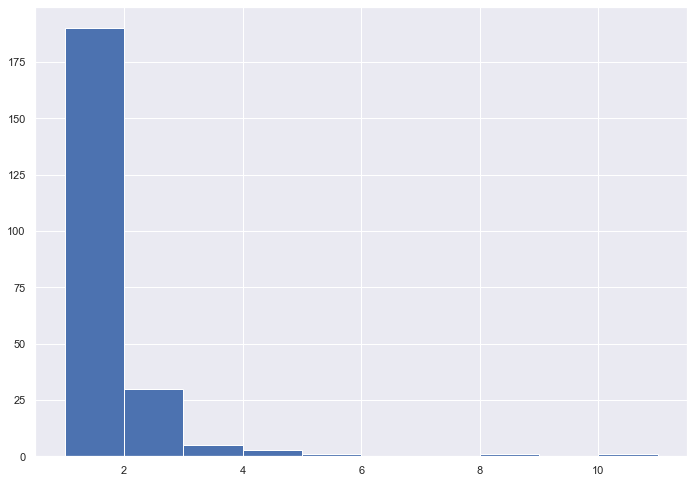

In [132]:
clinicaltrials.doi.value_counts().hist()

In [184]:
columns = ['doi', 'PMID', 'n_trials']
parse_cols = ['NCTId', 'OverallStatus', 'Phase', 'BriefTitle', 'Condition']

df = pd.DataFrame(columns=columns+parse_cols)

for r in results:
    if r['StudyFieldsResponse']['NStudiesFound'] > 0:
        doi = r['doi']
        pmid = r['StudyFieldsResponse']['Expression'].split("[")[0]
        n_trials = r['StudyFieldsResponse']['NStudiesFound']
        for _ in r['StudyFieldsResponse']['StudyFields']:
            row = []
            for pc in parse_cols:
                if pc in _:
                    if len(_[pc]) > 0:
                        x = _[pc][0]
                    else:
                        x = None
                    row.append(x)
            df.loc[len(df)+1] = [doi, pmid, n_trials] + row

Example article with complete clinical trials:

- DOI: https://doi.org/10.1126/science.1168175
- Landing page: https://science.sciencemag.org/content/324/5928/787
- PMID: https://pubmed.ncbi.nlm.nih.gov/19359544/
- Available clinical trials (https://clinicaltrials.gov/search/term=19359544%20%5BPUBMED-IDS%5D):
    - Phase 1: https://clinicaltrials.gov/ct2/show/record/NCT03829930?term=19359544+%5BPUBMED-IDS%5D&draw=2&rank=2
    - Phase 2: https://clinicaltrials.gov/ct2/show/record/NCT03196388?term=19359544+%5BPUBMED-IDS%5D&draw=2&rank=1

Relevant links to play around with clinical trials and pubmedIds

- https://clinicaltrials.gov/ct2/show/NCT01874691
- https://pubmed.ncbi.nlm.nih.gov/20031882/
- https://clinicaltrials.gov/search/term=20031882%20%5BPUBMED-IDS%5D